# Comparing Nuclei Size Distributions

<br/>

### Background

During early embryonic development in *Drosophila*, nuclei rapidly divide under a common plasma membrane without affecting the overall size of the embryo.
As a result, there is a characteristic change in size distribution of the nuclei after each stage of division.
In this notebook, we will use Student's t-test to compare the mean nuclear areas (in pixel counts) from micrographs of *Drosophila* embryos before and after one cycle of division.
We will assess how sample size and variability affect the p-value of our hypothesis test.



### Reference

[Dutta, S.; Djabrayan, N. J.-V.; Torquato, S.; Shvartsman, S. Y.; Krajnc, M. Self-Similar Dynamics of Nuclear Packing in the Early Drosophila Embryo. Biophysical Journal 2019, 117 (4), 743–750.](https://doi.org/10.1016/j.bpj.2019.07.009)


### Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, levene, ttest_ind

### Load Data

We use the [Pandas `read_csv` method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to load the data into a data frame (i.e., a table).

Then we are using the [`to_numpy` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html) of a Pandas data frame to convert the data frame into an array of numerical values.

Finally, we flatten the array of values using the [`flatten` method](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) of a numpy array.


In [2]:
# Load data into table
areas_before_df = pd.read_csv("data/nuclear_areas_before.csv", header=None, index_col=None)
areas_after_df = pd.read_csv("data/nuclear_areas_after.csv", header=None, index_col=None)

# Convert table to array
areas_before = areas_before_df.to_numpy()
areas_after = areas_after_df.to_numpy()

# Flatten array
areas_before = areas_before.flatten()
areas_after = areas_after.flatten()

In [3]:
print(areas_before)
print(areas_after)

[759 336 494 ... 374 383 213]
[175 264 298 ... 228 121 133]


### Visualize data

We visualize the distribution of nuclear areas before and after a round of division using histograms

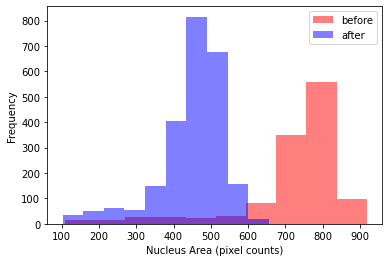

In [4]:
plt.figure(figsize=(6, 4))
plt.hist(areas_before, label="before", color="red", alpha = 0.5)
plt.hist(areas_after, label ="after", color="blue", alpha = 0.5)
plt.xlabel("Nucleus Area (pixel counts)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Discussion Question

Why do you think there is a leftward skew in the distribution of nuclear areas? Do you think the skew real or an artifact of the experimental method?

##### Hint

The scientists measure areas from pixel counts of nuclei imaged using microscopes. To automate this task, they pick an arbitrary rectangular space in the micrograph, segment the nuclei in that space, and count pixels corresponding to each nucleus.

### Trim the bottom 10% of Areas

In [5]:
trim_cutoff_before = np.percentile(areas_before, 10)
trim_cutoff_after = np.percentile(areas_after, 10)

areas_before_trimmed = areas_before[areas_before > trim_cutoff_before]
areas_after_trimmed = areas_after[areas_after > trim_cutoff_after]

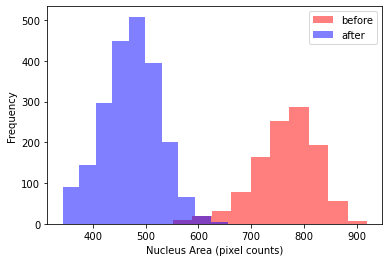

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(areas_before_trimmed, label="before", color="red", alpha = 0.5)
plt.hist(areas_after_trimmed, label ="after", color="blue", alpha = 0.5)
plt.xlabel("Nucleus Area (pixel counts)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Evaluate Assumption of Normality

In [7]:
normality_test_stat_before, normality_p_val_before = normaltest(areas_before_trimmed)
print(round(normality_p_val_before, 3))

0.0


In [8]:
normality_test_stat_after, normality_p_val_after = normaltest(areas_after_trimmed)
print(round(normality_p_val_after, 3))

0.455


The distribution of nuclear areas before division fails the normality test. There is sufficient evidence to conclude that the distribution of nuclear areas before cell division is not normal. We will proceed with our analysis, recognizing that the faulty assumptions may influence the results.

### Evaluate Assumption of Equal Variance

In [9]:
eq_var_test_stat, eq_var_p_val = levene(areas_before_trimmed, areas_after_trimmed)
print(round(eq_var_p_val, 3))

0.003


There is sufficient evidence to conclude that the sample distributions do not come from populations with equal variance. We will proceed with Welch's t-test.

### Run t-test

**Null Hypothesis:** The mean area of nuclei are the same before and after division.

**Alternative Hypothesis:** The mean area of nuclei are NOT the same before and after division.

In [10]:
t_stat, p_val = ttest_ind(
    areas_before_trimmed,
    areas_after_trimmed,
    equal_var=False          # This indicates use of Welch's t-test
)
print(p_val)

0.0


### Discussion Question

What does the p-value suggest?

### Effect of Sample Size

We repeat the analysis, this time on a random sub-sample of nuclear areas from each group. This analysis will model a scenario where we have limited access to data (for example, when data is expensive to collect).

In [11]:
sample_size = 10

In [12]:
# Sub-sample data with replacement
np.random.seed(177)
subsample_before = np.random.choice(areas_before_trimmed, size=sample_size, replace=True)
subsample_after = np.random.choice(areas_after_trimmed, size=sample_size, replace=True)

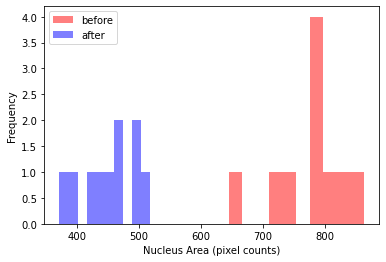

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(subsample_before, label="before", color="red", alpha = 0.5)
plt.hist(subsample_after, label ="after", color="blue", alpha = 0.5)
plt.xlabel("Nucleus Area (pixel counts)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [14]:
# Evaluate normality assumption
normality_test_stat_before, normality_p_val_before = normaltest(subsample_before)
print(f"Normality test p-val of areas before division: {round(normality_p_val_before, 3)}")

normality_test_stat_after, normality_p_val_after = normaltest(subsample_after)
print(f"Normality test p-val of areas after division: {round(normality_p_val_after, 3)}")

Normality test p-val of areas before division: 0.288
Normality test p-val of areas after division: 0.824


/Users/ajspakow/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [15]:
# Evaluate equal variance assumption
eq_var_test_stat, eq_var_p_val = levene(subsample_before, subsample_after)
print(f"Equal variance test p-val: {round(eq_var_p_val, 3)}")

Equal variance test p-val: 0.74


In [16]:
t_stat, p_val = ttest_ind(
    subsample_before,
    subsample_after,
    equal_var=True
)
print(p_val)

1.3835236941008757e-10


### Discussion Questions

- How did sample size affect our normality and equal variance tests?

- In this case, did our reduced sample size affect the results of our t-test?

- Are 10 samples enough to conclude that there is a significant difference in mean nucleus areas before and after division?

### Effect of Variability

We will repeat our analysis, again on our sub-sample of nuclear areas, but this time adding random noise to the data points. This analysis will model a scenario where our measurement instruments are imprecise.

In [17]:
magnitude_noise = 1000

In [18]:
np.random.seed(166)

noisy_subsample_before = np.zeros(len(subsample_before))
noisy_subsample_after = np.zeros(len(subsample_after))

# Add random noise to each data point
for i in range(len(subsample_before)):
    noise = (np.random.rand(2) - 0.5) * magnitude_noise
    noisy_subsample_before[i] = subsample_before[i] + noise[0]
    noisy_subsample_after[i] = subsample_after[i] + noise[1]

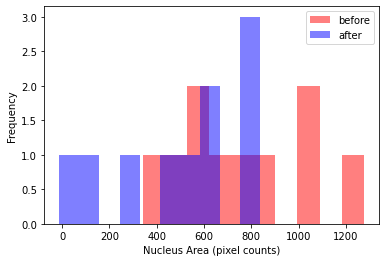

In [19]:
plt.figure(figsize=(6, 4))
plt.hist(noisy_subsample_before, label="before", color="red", alpha = 0.5)
plt.hist(noisy_subsample_after, label ="after", color="blue", alpha = 0.5)
plt.xlabel("Nucleus Area (pixel counts)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [20]:
# Evaluate normality assumption
normality_test_stat_before, normality_p_val_before = normaltest(noisy_subsample_before)
print(f"Normality test p-val of areas before division: {round(normality_p_val_before, 3)}")

normality_test_stat_after, normality_p_val_after = normaltest(noisy_subsample_after)
print(f"Normality test p-val of areas after division: {round(normality_p_val_after, 3)}")

Normality test p-val of areas before division: 0.776
Normality test p-val of areas after division: 0.551


In [21]:
# Evaluate equal variance assumption
eq_var_test_stat, eq_var_p_val = levene(noisy_subsample_before, noisy_subsample_after)
print(f"Equal variance test p-val: {round(eq_var_p_val, 3)}")

Equal variance test p-val: 0.99


In [22]:
t_stat, p_val = ttest_ind(
    noisy_subsample_before,
    noisy_subsample_after,
    equal_var=True
)
print(p_val)

0.08285804004505043


### Discussion Question

What happens to our confidence if we increase variability in data points due to noise in experimental measurements?